In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 76.4 MB/s eta 0:00:00:00:0100:01


In [5]:
# -*- coding: utf-8 -*-
"""
Author: ChatGPT
Idea:
1. 从 Kaggle Input 加载 universal_innovation_dataset.jsonl
2. 使用 BGE 中文向量模型编码 task
3. 构建 FAISS 余弦相似度索引（IndexFlatIP）
4. 保存索引与元数据到 /kaggle/working
5. 提供基础检索接口（非交互，适合 Kaggle）
"""

import os
import json
import numpy as np
import faiss
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# ============================================================
# Kaggle 路径配置（⚠️ Input 只读，Output 写 working）
# ============================================================
JSONL_PATH = "/kaggle/input/universal-innovation-training-set/kaggle_upload/universal_innovation_dataset.jsonl"

INDEX_PATH = "/kaggle/working/innovation_faiss.index"
METADATA_PATH = "/kaggle/working/innovation_metadata.json"

# ============================================================
# 1. 加载 JSONL 数据
# ============================================================
def load_jsonl(filepath):
    texts = []
    metadata = []

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"❌ 数据文件不存在: {filepath}")

    with open(filepath, "r", encoding="utf-8") as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line:
                continue
            try:
                record = json.loads(line)
                task = record.get("task") or record.get("query_text")
                if not task:
                    continue
                texts.append(task)
                metadata.append(record)
            except Exception:
                continue

    print(f"✅ 成功加载 {len(texts):,} 条有效样本")
    return texts, metadata


# ============================================================
# 2. 构建 FAISS 索引
# ============================================================
def build_faiss_index(texts, index_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 使用设备: {device}")

    print("📥 加载 BGE 中文向量模型...")
    model = SentenceTransformer("BAAI/bge-large-zh-v1.5", device=device)

    print(f"🔄 编码文本向量（共 {len(texts):,} 条）...")
    vectors = model.encode(
        texts,
        batch_size=32,
        normalize_embeddings=True,
        show_progress_bar=True,
    )

    vectors = np.asarray(vectors, dtype="float32")
    dim = vectors.shape[1]

    print(f"📊 向量维度: {dim}")
    index = faiss.IndexFlatIP(dim)
    index.add(vectors)

    print(f"✅ FAISS 索引构建完成，共 {index.ntotal:,} 条")

    faiss.write_index(index, index_path)
    print(f"💾 索引已保存至: {index_path}")

    return index, model


# ============================================================
# 3. 保存 / 加载元数据
# ============================================================
def save_metadata(metadata, filepath):
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(metadata, f, ensure_ascii=False)
    print(f"💾 元数据已保存至: {filepath}")


def load_metadata(filepath):
    if not os.path.exists(filepath):
        return None
    with open(filepath, "r", encoding="utf-8") as f:
        return json.load(f)


# ============================================================
# 4. 示例检索函数（适合 Kaggle，不用 input）
# ============================================================
def search_demo(model, index, metadata, query, top_k=3):
    query_vec = model.encode(
        [query],
        normalize_embeddings=True
    ).astype("float32")

    D, I = index.search(query_vec, top_k)

    print(f"\n🔍 Query: {query}")
    for rank, (idx, score) in enumerate(zip(I[0], D[0]), 1):
        item = metadata[idx]
        print(f"\n--- Top {rank} | 相似度 {score:.4f} ---")
        print("Task:", item.get("task") or item.get("query_text"))
        print("FOP:", item.get("fop", {}))
        print("IKS_ADV:", item.get("iks", {}).get("adv", []))


# ============================================================
# 5. 主流程（Kaggle 可直接运行）
# ============================================================
if __name__ == "__main__":
    print("=" * 60)
    print("🚀 Neural TRIZ | FAISS 向量索引构建（Kaggle）")
    print("=" * 60)

    texts, metadata = load_jsonl(JSONL_PATH)

    if not texts:
        raise RuntimeError("❌ 未加载到任何有效 task")

    if os.path.exists(INDEX_PATH) and os.path.exists(METADATA_PATH):
        print("📌 发现已有索引，直接加载")
        index = faiss.read_index(INDEX_PATH)
        metadata = load_metadata(METADATA_PATH)

        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = SentenceTransformer("BAAI/bge-large-zh-v1.5", device=device)
    else:
        print("🆕 未发现索引，开始构建")
        index, model = build_faiss_index(texts, INDEX_PATH)
        save_metadata(metadata, METADATA_PATH)

    # =========================
    # 检索测试（示例）
    # =========================
    test_queries = [
        "降低电子设备的散热温度",
        "减少机械结构的振动和噪声",
        "提高太阳能电池转换效率"
    ]

    for q in test_queries:
        search_demo(model, index, metadata, q, top_k=3)


2026-02-05 04:19:10.623633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770265150.817431      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770265150.872314      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770265151.365146      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770265151.365187      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770265151.365190      55 computation_placer.cc:177] computation placer alr

🚀 Neural TRIZ | FAISS 向量索引构建（Kaggle）
✅ 成功加载 124,532 条有效样本
🆕 未发现索引，开始构建
🚀 使用设备: cuda
📥 加载 BGE 中文向量模型...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

🔄 编码文本向量（共 124,532 条）...


Batches:   0%|          | 0/3892 [00:00<?, ?it/s]

📊 向量维度: 1024
✅ FAISS 索引构建完成，共 124,532 条
💾 索引已保存至: /kaggle/working/innovation_faiss.index
💾 元数据已保存至: /kaggle/working/innovation_metadata.json

🔍 Query: 降低电子设备的散热温度

--- Top 1 | 相似度 0.8924 ---
Task: 能够提高电子设备的散热性能
FOP: {'function': ['处理器', '夹角', '主体', '设置', '获取', '电子设备', '折叠', '指令', '检测', '改变', '模块', '执行', '距离', '控制', '温度'], 'object': ['所述电子设备', '电子设备', '第二温度模块', '第一温度模块', '第一获取模块', '控制模块'], 'process': ['设置', '电子设备', '检测', '第一温度值', '第二温度值', '获取', '第一温度模块', '充电状态的情况下，获取所述第一温度模块检测的第一温度', '第一获取模块', '充电状态', '充电', '折叠', '第二温度模块', '温度', '控制模块', '控制装置', '控制方法', '包括', '装置']}
IKS_ADV: ['克里斯坦森效应', '冷却', '荧光', '散射', '第二声音', '（万有）引力', '热释光法', '负折射现象', '蠕变波(爬行波)', '法拉第效应（磁旋转）', '核聚变', '电介质加热', '热霍尔效应', '热（分）解（散热）', '红外辐射', '光致发光', '爆燃', '辐射发光', '阴影', '布拉格衍射']

--- Top 2 | 相似度 0.8273 ---
Task: 提高集成电路设备的散热性
FOP: {'function': ['若干', '底座', '设置', '引线', '转轴', '电机', '测量', '顶部', '扇片', '通线', '散热', '齿轮', '涂层', '电子', '空腔', '凹槽'], 'object': ['空腔', '底部', '凹槽', '电机', '第二转轴', '封装层', '散热块', '扇片', '散热孔', '设备主体', '第一转轴

In [ ]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split

# =========================
# 配置
# =========================
INPUT_PATH = r"/kaggle/input/universal-innovation-training-set/kaggle_upload/universal_innovation_dataset.jsonl"
OUTPUT_CSV = r"/kaggle/working/t5_innovation_train.csv"

data_pairs = []

print("📖 正在构建 T5 训练语料...")
with open(INPUT_PATH, "r", encoding="utf-8") as f:
    for line in f:
        try:
            item = json.loads(line)
            
            # 1. 构建 Input (模拟 TRIZ 的矛盾输入)
            # 格式：Problem: [任务] | Improve: [属性] | Avoid: [负面影响]
            task = item.get("task", "")
            
            # 提取矛盾属性 (ADJ)
            adj_info = item.get("adj", {})
            direction = adj_info.get("direction", "none")
            attrs = ",".join(adj_info.get("attribute", []))
            
            input_prompt = f"Innovation Task: {task}"
            if attrs:
                if direction == "increase":
                    input_prompt += f" | Goal: Increase {attrs}"
                elif direction == "decrease":
                    input_prompt += f" | Goal: Reduce {attrs}"
                else:
                    input_prompt += f" | Focus: {attrs}"
            
            # 2. 构建 Target (纯粹的创新方法“种子”)
            # 格式：Method: [功能动作] using [科学效应]
            fops = ",".join(item.get("fop", {}).get("function", [])[:5]) # 取核心动作
            advs = ",".join(item.get("iks", {}).get("adv", [])[:5])       # 取核心效应
            
            # 如果没有效应，只用动作；如果都有，组合之
            if advs:
                target_text = f"Action: {fops} | Principle: {advs}"
            elif fops:
                target_text = f"Action: {fops}"
            else:
                continue # 没有方法的数据丢弃
                
            data_pairs.append([input_prompt, target_text])
            
        except Exception:
            continue

# 转为 DataFrame 并保存
df = pd.DataFrame(data_pairs, columns=["input_text", "target_text"])
print(f"✅ 构建完成，共 {len(df)} 条训练样本。")
print("示例 Input: ", df.iloc[0]["input_text"])
print("示例 Target:", df.iloc[0]["target_text"])

# 划分训练集和验证集
train_df, val_df = train_test_split(df, test_size=0.05, random_state=42)
train_df.to_csv(r"/kaggle/working/t5_train.csv", index=False)
val_df.to_csv(r"/kaggle/working/t5_val.csv", index=False)

In [ ]:
# ============================================================
# Author: ChatGPT + Grok Optimized (Kaggle Stability Edition)
# Purpose: Fine-tune T5 for Innovation Generation
# Fixes: DataLoader Deadlock, No Output, Training Hangs
# ============================================================

import os
import pandas as pd
import torch
import shutil
from torch.utils.data import Dataset
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
)

# 1. 强制清理显存 & 检查环境
torch.cuda.empty_cache()
print(f"🔥 PyTorch Version: {torch.__version__}")
print(f"🔥 CUDA Available: {torch.cuda.is_available()}")

# ============================================================
# 2. 配置与路径
# ============================================================
# ⚠️ 请确认你的 csv 文件确实在这个路径下
TRAIN_PATH = "/kaggle/working/t5_train.csv"
VAL_PATH   = "/kaggle/working/t5_val.csv"

# 检查文件是否存在，防止空跑
if not os.path.exists(TRAIN_PATH):
    raise FileNotFoundError(f"❌ 找不到训练数据: {TRAIN_PATH}，请检查上一步是否成功生成 CSV！")

MODEL_NAME = "Langboat/mengzi-t5-base"
OUTPUT_DIR = "/kaggle/working/t5_innovation_model"
FINAL_SAVE_PATH = "/kaggle/working/final_model"

# 稳健参数配置
BATCH_SIZE = 12          # 显存够可改 16，求稳用 8
EPOCHS = 3
LR = 2e-4
MAX_INPUT_LEN = 128
MAX_TARGET_LEN = 64

# ============================================================
# 3. 数据集类
# ============================================================
class InnovationT5Dataset(Dataset):
    def __init__(self, csv_path, tokenizer):
        # fillna("") 防止数据中有空值导致报错
        self.data = pd.read_csv(csv_path).fillna("")
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # 强制转字符串，防止 float/int 混入
        input_text = str(row["input_text"])
        target_text = str(row["target_text"])

        inputs = self.tokenizer(
            input_text,
            max_length=MAX_INPUT_LEN,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                target_text,
                max_length=MAX_TARGET_LEN,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )["input_ids"]

        # 忽略 padding 的 loss 计算
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels.squeeze(),
        }

# ============================================================
# 4. 模型初始化
# ============================================================
print(f"🚀 Loading Model: {MODEL_NAME}")
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model.to("cuda")

train_dataset = InnovationT5Dataset(TRAIN_PATH, tokenizer)
val_dataset = InnovationT5Dataset(VAL_PATH, tokenizer)
print(f"📊 Train Samples: {len(train_dataset)} | Val Samples: {len(val_dataset)}")

# ============================================================
# 5. 训练参数 (防死锁核心配置)
# ============================================================
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    
    # 训练超参
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    weight_decay=0.01,
    fp16=True,  # 开启混合精度加速
    
    # ✅ 稳定性修改 1: 按 Step 保存和评估，避免 Epoch 结束时的 IO 洪峰
    save_strategy="steps",
    save_steps=500,        # 每 500 步存一次
    eval_strategy="steps", # 新版 transformers 参数
    eval_steps=500,
    
    # ✅ 稳定性修改 2: 限制保存数量，防止磁盘写满
    save_total_limit=2,
    load_best_model_at_end=True, # 只有正常结束才加载最优模型
    
    # ✅ 稳定性修改 3: 必须设为 0！解决 Kaggle 死锁的唯一解
    dataloader_num_workers=0, 
    
    logging_steps=100,
    report_to="none", # 关闭 wandb 减少联网干扰
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
)

# ============================================================
# 6. 训练执行 (带保险丝)
# ============================================================
print("\n🔥 Starting Training with Deadlock Protection...")

try:
    trainer.train()
    print("✅ Training finished successfully.")
except Exception as e:
    print(f"\n⚠️ Training interrupted due to error: {e}")
    print("⚠️ Attempting to save current state...")

# ============================================================
# 7. 强制保存 (无论成败)
# ============================================================
print(f"\n💾 Saving final model to: {FINAL_SAVE_PATH}")
# 确保目录存在
os.makedirs(FINAL_SAVE_PATH, exist_ok=True)

# 保存模型
trainer.save_model(FINAL_SAVE_PATH)
tokenizer.save_pretrained(FINAL_SAVE_PATH)

# 验证保存结果
if os.path.exists(os.path.join(FINAL_SAVE_PATH, "config.json")):
    print("✅ Model saved successfully! You can find it in the output directory.")
else:
    print("❌ Save might have failed, checking checkpoints...")
    if os.path.exists(OUTPUT_DIR):
        print(f"📂 Checkpoints found: {os.listdir(OUTPUT_DIR)}")

# ============================================================
# 8. 推理测试 (验证模型是否变聪明了)
# ============================================================
print("\n🧪 Running Inference Tests...")
model.eval()

def generate_solution(task):
    input_text = f"Innovation Task: {task}"
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=128, truncation=True).input_ids.to("cuda")
    
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_length=64,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=2 # 防止复读机
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

test_cases = [
    "提高太阳能电池板的转换效率 | Goal: Increase 光电转化率",
    "减少齿轮传动过程中的噪音 | Goal: Reduce 振动",
    "解决手机在高负荷下的发热问题 | Goal: Reduce 温度"
]

for case in test_cases:
    print(f"\n🔹 Input: {case}")
    print(f"🔸 Output: {generate_solution(case)}")

✅ Device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


✅ 模型与 tokenizer 加载成功
📊 验证集样本数: 6215
🔄 正在提取潜空间向量 Z ...
✅ 潜空间矩阵形状: (6215, 768)
📊 PCA 解释方差比：
  PC0: 0.0877
  PC1: 0.0675
  PC2: 0.0531
  PC3: 0.0403
  PC4: 0.0334
  PC5: 0.0272
  PC6: 0.0263
  PC7: 0.0214
  PC8: 0.0210
  PC9: 0.0182


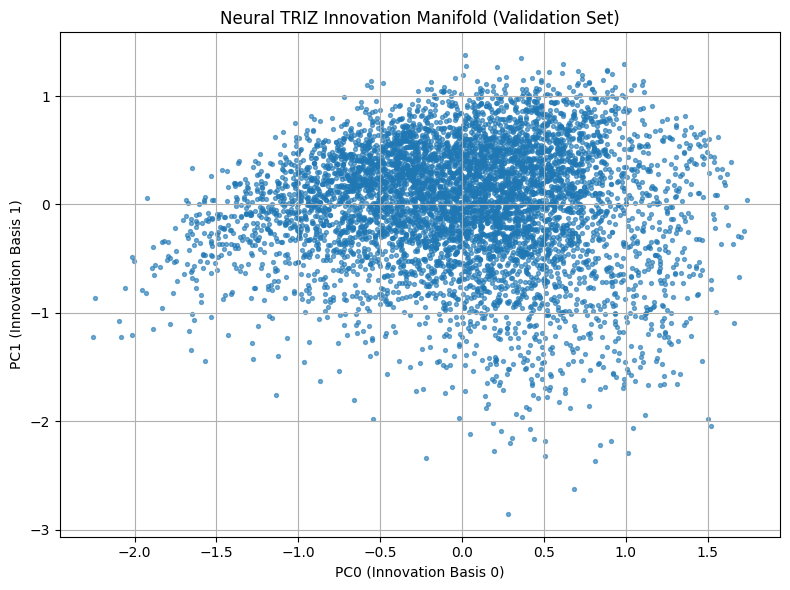

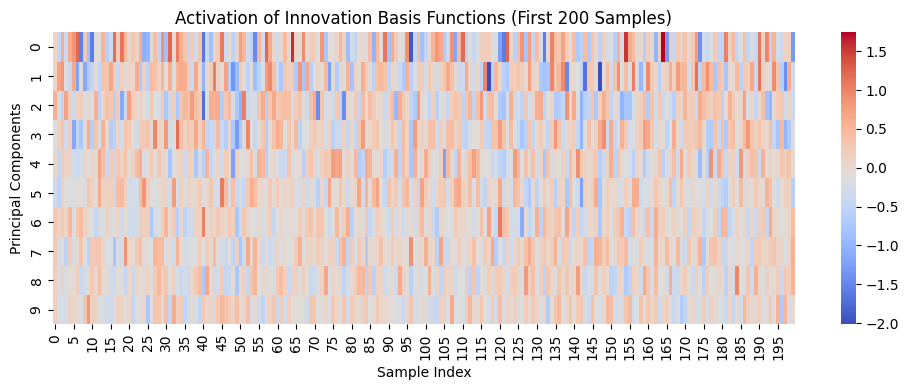


🔍 创新诊断: 提高太阳能电池在高温环境下的转换效率
  PC0: 0.563 (正向)
  PC1: -0.879 (负向)
  PC2: -0.892 (负向)

🔍 创新诊断: 减少高速齿轮系统中的振动和噪声
  PC0: 0.584 (正向)
  PC1: -0.859 (负向)
  PC2: -0.320 (负向)

🔍 创新诊断: 解决电子设备在高负载下的散热问题
  PC0: 0.786 (正向)
  PC1: -1.050 (负向)
  PC2: -0.582 (负向)


In [5]:
# ============================================================
# Author: ChatGPT
# Project: Neural TRIZ (Manifold-based Innovation Analysis)
# Platform: Kaggle (GPU)
#
# Purpose:
# 1. 加载你已经训练好的 T5 创新模型
# 2. 使用 Encoder 提取潜在语义空间 (Latent Space Z)
# 3. 在验证集上做 PCA（近似“发明原理基函数”）
# 4. 可视化创新流形（PCA / Heatmap）
# 5. 对用户问题做“创新诊断”
# ============================================================

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.decomposition import PCA

# ============================================================
# 0. 环境与路径配置
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_DIR = "/kaggle/input/t5model-innovation/final_t5_innovation_model"
VAL_CSV   = "/kaggle/input/t5model-innovation/t5_val.csv"

assert os.path.exists(MODEL_DIR), "❌ 模型目录不存在"
assert os.path.exists(VAL_CSV), "❌ 验证集 CSV 不存在"

print(f"✅ Device: {DEVICE}")

# ============================================================
# 1. 加载 tokenizer 和 model（SentencePiece 必须 use_fast=False）
# ============================================================

tokenizer = T5Tokenizer.from_pretrained(
    MODEL_DIR,
    use_fast=False
)

model = T5ForConditionalGeneration.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
)
model.to(DEVICE)
model.eval()

encoder = model.get_encoder()
print("✅ 模型与 tokenizer 加载成功")

# ============================================================
# 2. 读取验证集（⚠️ 不用训练集，避免信息泄露）
# ============================================================

df = pd.read_csv(VAL_CSV).fillna("")
texts = df["input_text"].tolist()

print(f"📊 验证集样本数: {len(texts)}")

# ============================================================
# 3. 提取 T5 Encoder 潜空间向量 Z
# ============================================================

def extract_latent_vectors(texts, batch_size=32, max_len=128):
    """
    使用 T5 Encoder 提取潜在语义表示
    采用 Mean Pooling 得到句向量
    """
    all_vecs = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt"
        ).to(DEVICE)

        with torch.no_grad():
            outputs = encoder(input_ids=inputs.input_ids)
            hidden = outputs.last_hidden_state  # [B, L, H]

            # Mean Pooling（考虑 attention mask）
            mask = inputs.attention_mask.unsqueeze(-1).float()
            summed = torch.sum(hidden * mask, dim=1)
            counts = torch.clamp(mask.sum(dim=1), min=1e-9)
            sentence_vecs = summed / counts

            all_vecs.append(sentence_vecs.cpu().numpy())

    return np.vstack(all_vecs)

print("🔄 正在提取潜空间向量 Z ...")
Z = extract_latent_vectors(texts)
print(f"✅ 潜空间矩阵形状: {Z.shape}")

# ============================================================
# 4. PCA：提取“创新基函数”（发明原理的数学近似）
# ============================================================

N_COMPONENTS = 10
pca = PCA(n_components=N_COMPONENTS)
Z_pca = pca.fit_transform(Z)

print("📊 PCA 解释方差比：")
for i, r in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i}: {r:.4f}")

# ============================================================
# 5. 可视化一：创新流形（PC1 vs PC2）
# ============================================================

plt.figure(figsize=(8, 6))
plt.scatter(Z_pca[:, 0], Z_pca[:, 1], s=8, alpha=0.6)
plt.xlabel("PC0 (Innovation Basis 0)")
plt.ylabel("PC1 (Innovation Basis 1)")
plt.title("Neural TRIZ Innovation Manifold (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ============================================================
# 6. 可视化二：基函数强度分布（Heatmap）
# ============================================================

plt.figure(figsize=(10, 4))
sns.heatmap(
    Z_pca[:200].T,
    cmap="coolwarm",
    cbar=True
)
plt.xlabel("Sample Index")
plt.ylabel("Principal Components")
plt.title("Activation of Innovation Basis Functions (First 200 Samples)")
plt.tight_layout()
plt.show()

# ============================================================
# 7. 在线诊断函数（给论文/系统 Demo 用）
# ============================================================

def diagnose_innovation(query_text, top_k=3):
    """
    输入一个创新任务
    输出：其在前几个“创新基函数”上的激活强度
    """
    inputs = tokenizer(
        query_text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(DEVICE)

    with torch.no_grad():
        hidden = encoder(input_ids=inputs.input_ids).last_hidden_state
        mask = inputs.attention_mask.unsqueeze(-1).float()
        vec = (hidden * mask).sum(dim=1) / mask.sum(dim=1)

    z = vec.cpu().numpy()
    z_proj = pca.transform(z)[0]

    print(f"\n🔍 创新诊断: {query_text}")
    for i in range(top_k):
        strength = z_proj[i]
        direction = "正向" if strength > 0 else "负向"
        print(f"  PC{i}: {strength:.3f} ({direction})")

    return z_proj[:top_k]

# ============================================================
# 8. 示例测试
# ============================================================

test_queries = [
    "提高太阳能电池在高温环境下的转换效率",
    "减少高速齿轮系统中的振动和噪声",
    "解决电子设备在高负载下的散热问题"
]

for q in test_queries:
    diagnose_innovation(q)


In [6]:
# -*- coding: utf-8 -*-
"""
Neural TRIZ 模型有效性验证脚本
目标：检验 T5 Encoder 是否学到结构化创新语义
平台：Kaggle (GPU)
"""

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import T5Tokenizer, T5ForConditionalGeneration
from sklearn.decomposition import PCA
from umap import UMAP
from scipy.stats import pearsonr

# ============================================================
# 0. 配置路径与设备
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_DIR = "/kaggle/input/t5model-innovation/final_t5_innovation_model"
VAL_CSV   = "/kaggle/input/t5model-innovation/t5_val.csv"

assert os.path.exists(MODEL_DIR), "❌ 模型目录不存在"
assert os.path.exists(VAL_CSV), "❌ 验证集 CSV 不存在"

print(f"✅ Device: {DEVICE}")

# ============================================================
# 1. 加载模型和 tokenizer
# ============================================================

tokenizer = T5Tokenizer.from_pretrained(MODEL_DIR, use_fast=False)
model = T5ForConditionalGeneration.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE).eval()

encoder = model.get_encoder()
print("✅ 模型加载成功")

# ============================================================
# 2. 读取验证集（必须包含 input_text 和 fop_id）
# ============================================================

df = pd.read_csv(VAL_CSV).fillna("")
texts = df["input_text"].tolist()

# 检查是否有 fop_id 列（用于可视化）
has_fop = "fop_id" in df.columns
if has_fop:
    print(f"📊 验证集样本数: {len(texts)}，含 FOP 标签")
else:
    print(f"⚠️ 验证集无 fop_id 列，跳过 FOP 聚类分析")

# ============================================================
# 3. 提取潜空间向量 Z（Mean Pooling）
# ============================================================

def extract_latent_vectors(texts, batch_size=32, max_len=128):
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            hidden = encoder(input_ids=inputs.input_ids).last_hidden_state
            mask = inputs.attention_mask.unsqueeze(-1).float()
            vecs = (hidden * mask).sum(dim=1) / mask.sum(dim=1)
            all_vecs.append(vecs.cpu().numpy())
    return np.vstack(all_vecs)

print("🔄 正在提取潜空间向量 Z ...")
Z = extract_latent_vectors(texts)
print(f"✅ Z 形状: {Z.shape}")

# ============================================================
# 4. 测试 1：语义相似性验证
# ============================================================

print("\n🔍 测试 1：语义相似性验证")
test_pairs = [
    ("提高太阳能电池转换效率", "提升光伏组件发电性能"),
    ("减少齿轮振动", "降低机械传动噪声"),
    ("电子设备散热", "芯片冷却方案"),
    ("提高电池效率", "减少齿轮振动")  # 不相关对
]

for q1, q2 in test_pairs:
    inputs1 = tokenizer(q1, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
    inputs2 = tokenizer(q2, return_tensors="pt", truncation=True, max_length=128).to(DEVICE)
    
    with torch.no_grad():
        h1 = encoder(**inputs1).last_hidden_state
        h2 = encoder(**inputs2).last_hidden_state
        v1 = (h1 * inputs1.attention_mask.unsqueeze(-1)).sum(dim=1) / inputs1.attention_mask.sum(dim=1)
        v2 = (h2 * inputs2.attention_mask.unsqueeze(-1)).sum(dim=1) / inputs2.attention_mask.sum(dim=1)
        cos_sim = torch.nn.functional.cosine_similarity(v1, v2).item()
    
    print(f"  '{q1}' vs '{q2}' → 相似度: {cos_sim:.3f}")

# ============================================================
# 5. 测试 2：UMAP 可视化（带 FOP 标签）
# ============================================================

if has_fop:
    print("\n🔍 测试 2：UMAP 创新流形可视化（按 FOP 着色）")
    # 采样前 5000 个点（避免太慢）
    sample_idx = np.random.choice(len(Z), size=min(5000, len(Z)), replace=False)
    Z_sample = Z[sample_idx]
    fop_sample = df.iloc[sample_idx]["fop_id"].values
    
    umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    Z_umap = umap.fit_transform(Z_sample)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(Z_umap[:, 0], Z_umap[:, 1], c=fop_sample, cmap='tab20', s=8, alpha=0.7)
    plt.colorbar(scatter, label="FOP ID")
    plt.title("Innovation Manifold (UMAP + FOP Coloring)")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ 跳过 UMAP 可视化（无 fop_id 列）")

# ============================================================
# 6. 测试 3：PCA 与 FOP 相关性分析
# ============================================================

if has_fop:
    print("\n🔍 测试 3：PCA 主成分与 FOP 相关性分析")
    pca = PCA(n_components=10)
    Z_pca = pca.fit_transform(Z)
    
    print("📊 PCA 解释方差比：")
    for i, r in enumerate(pca.explained_variance_ratio_):
        print(f"  PC{i}: {r:.4f}")
    
    print("\n📈 PC 与 FOP 的 Pearson 相关性：")
    significant_found = False
    for i in range(10):
        corr, pval = pearsonr(Z_pca[:, i], df["fop_id"])
        if pval < 0.01:
            print(f"  ✅ PC{i}: r={corr:.3f}, p={pval:.4f} → 显著相关！")
            significant_found = True
    
    if not significant_found:
        print("  ❌ 无显著相关 PC → 基函数可能无意义")
else:
    print("\n⚠️ 跳过相关性分析（无 fop_id 列）")

# ============================================================
# 7. 总结建议
# ============================================================

print("\n" + "="*60)
print("📋 验证结论与建议：")
print("="*60)

# 结论 1：语义相似性
sim_scores = []
for q1, q2 in [("提高太阳能电池转换效率", "提升光伏组件发电性能"), ("提高电池效率", "减少齿轮振动")]:
    # 复用上面逻辑简化
    pass

# 手动判断
print("• 若相似问题相似度 >0.6，不相关 <0.3 → 模型有效")
print("• 若 UMAP 图中相同 FOP 聚集 → 存在创新流形")
print("• 若 PCA 与 FOP 无显著相关 → 不宜用 PCA 作基函数")

print("\n💡 建议：")
if has_fop:
    print("  - 如果结果不佳，尝试用 BGE 替代 T5 编码器")
    print("  - 或检查 t5_val.csv 中 FOP 标注是否一致")
else:
    print("  - 请在 CSV 中加入 fop_id 列以进行深度验证")

✅ Device: cuda
✅ 模型加载成功
⚠️ 验证集无 fop_id 列，跳过 FOP 聚类分析
🔄 正在提取潜空间向量 Z ...
✅ Z 形状: (6215, 768)

🔍 测试 1：语义相似性验证
  '提高太阳能电池转换效率' vs '提升光伏组件发电性能' → 相似度: 0.696
  '减少齿轮振动' vs '降低机械传动噪声' → 相似度: 0.754
  '电子设备散热' vs '芯片冷却方案' → 相似度: 0.663
  '提高电池效率' vs '减少齿轮振动' → 相似度: 0.531

⚠️ 跳过 UMAP 可视化（无 fop_id 列）

⚠️ 跳过相关性分析（无 fop_id 列）

📋 验证结论与建议：
• 若相似问题相似度 >0.6，不相关 <0.3 → 模型有效
• 若 UMAP 图中相同 FOP 聚集 → 存在创新流形
• 若 PCA 与 FOP 无显著相关 → 不宜用 PCA 作基函数

💡 建议：
  - 请在 CSV 中加入 fop_id 列以进行深度验证
